# Zillow Clustering

## Acquire

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", None)

from os import path

from env import host, user, password, get_db_url

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [3]:
# zillow_query = """
# SELECT prop.*, pred.logerror, pred.transactiondate, ac.airconditioningdesc, ar.architecturalstyledesc, bu.buildingclassdesc, he.heatingorsystemdesc, la.propertylandusedesc, st.storydesc, co.typeconstructiondesc
# FROM properties_2017 AS prop
# JOIN (
# 	SELECT parcelid, MAX(logerror) as logerror, MAX(transactiondate) AS transactiondate
# 	FROM predictions_2017
# 	GROUP BY parcelid) AS pred ON prop.parcelid = pred.parcelid
# LEFT JOIN airconditioningtype AS ac USING(airconditioningtypeid)
# LEFT JOIN architecturalstyletype AS ar USING(architecturalstyletypeid)
# LEFT JOIN buildingclasstype AS bu USING(buildingclasstypeid)
# LEFT JOIN heatingorsystemtype AS he USING(heatingorsystemtypeid)
# LEFT JOIN propertylandusetype AS la USING(propertylandusetypeid)
# LEFT JOIN storytype AS st USING(storytypeid)
# LEFT JOIN typeconstructiontype as co USING(typeconstructiontypeid)
# WHERE prop.latitude IS NOT NULL
# AND prop.longitude IS NOT NULL;"""

In [4]:
def get_zillow_data():
    # query zillow data
    zillow_query = """
    SELECT prop.*, pred.logerror, pred.transactiondate, ac.airconditioningdesc, ar.architecturalstyledesc, bu.buildingclassdesc, he.heatingorsystemdesc, la.propertylandusedesc, st.storydesc, co.typeconstructiondesc
    FROM properties_2017 AS prop
    JOIN predictions_2017 AS pred USING(parcelid)
    LEFT JOIN airconditioningtype AS ac USING(airconditioningtypeid)
    LEFT JOIN architecturalstyletype AS ar USING(architecturalstyletypeid)
    LEFT JOIN buildingclasstype AS bu USING(buildingclasstypeid)
    LEFT JOIN heatingorsystemtype AS he USING(heatingorsystemtypeid)
    LEFT JOIN propertylandusetype AS la USING(propertylandusetypeid)
    LEFT JOIN storytype AS st USING(storytypeid)
    LEFT JOIN typeconstructiontype as co USING(typeconstructiontypeid)
    WHERE prop.latitude IS NOT NULL
    AND prop.longitude IS NOT NULL;"""
    
    # get database url
    zillow_url = get_db_url("zillow")
    
    # get pandas to read sql query + db url and return a DataFrame if the .csv of the data doesn't already exist
    if path.exists("zillow_clustering.csv"):
        df = pd.read_csv("zillow_clustering.csv", index_col=0)
    else:
        df = pd.read_sql(zillow_query, zillow_url)
        df.to_csv("zillow_clustering.csv")
    
    return df

In [5]:
df = get_zillow_data()
print(df.shape)
df.head()

(77580, 68)


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [6]:
df.isnull().sum().sort_values(ascending=False)

buildingclassdesc       77565
buildingclasstypeid     77565
finishedsquarefeet13    77538
basementsqft            77530
storydesc               77530
                        ...  
assessmentyear              0
logerror                    0
transactiondate             0
propertylandusedesc         0
id                          0
Length: 68, dtype: int64

In [7]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.758000e+04,7.758000e+04,25007.000000,207.000000,50.000000,77580.000000,77580.000000,15.000000,49810.000000,76964.000000,614.0,6037.000000,77379.000000,73924.000000,42.000000,3027.000000,6037.000000,386.000000,77580.000000,8289.000000,76964.000000,25520.000000,25520.000000,1539.0,49572.000000,7.758000e+04,7.758000e+04,6.932200e+04,16174.0,869.000000,465.0,1074.0,15079.0,77580.000000,7.758000e+04,76108.000000,77580.000000,30974.000000,77530.000000,77580.000000,50.0,10106.000000,223.000000,50704.000000,2393.000000,70.000000,77310.000000,17599.000000,172.0,7.746500e+04,7.757900e+04,77580.0,7.757800e+04,77575.000000,2900.000000,7.733300e+04,77580.000000
mean,1.495404e+06,1.300828e+07,1.812013,7.386473,679.720000,2.298492,3.053222,3.933333,6.533728,2.316388,66.0,1366.165314,1784.925923,1760.274945,1388.761905,2354.491245,1381.388935,2082.500000,6048.813998,1.191217,2.250104,1.815282,350.047061,1.0,3.921811,3.400837e+07,-1.182037e+08,2.997309e+04,1.0,517.930955,1.0,1.0,1.0,261.824465,6.049124e+07,33684.165817,2534.522235,187725.110544,96586.691539,1.476257,7.0,1.009598,6.040359,1.110307,305.460928,216.385714,1968.611396,1.434286,1.0,1.892796e+05,4.901476e+05,2016.0,3.011500e+05,5995.927626,14.088276,6.049667e+13,0.016800
std,8.609700e+05,3.519376e+06,2.965768,2.728030,689.703546,0.996726,1.140472,0.258199,1.722082,0.979684,0.0,670.701336,954.247864,934.349898,122.220874,1186.985442,725.792665,1240.382784,20.747162,0.490980,0.966486,0.588340,261.646070,0.0,3.594770,2.652856e+05,3.594078e+05,1.233042e+05,0.0,156.569664,0.0,0.0,0.0,5.141564,2.058953e+05,47212.464556,801.445328,165045.086058,3793.527616,2.823673,0.0,0.118572,0.556035,1.169955,238.735241,190.177514,23.793037,0.544515,0.0,2.304095e+05,6.537942e+05,0.0,4.927219e+05,7628.816490,2.181281,1.533329e+12,0.170739
min,3.490000e+02,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,7.521430e+05,1.153820e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,1.0,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,1.0,8.417100e+04,2.068990e+05,2016.0,8.529325e+04,2712.650000,14.000000,6.037311e+13,-0.024310
50%,1.498256e+06,1.253056e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77580 entries, 0 to 77579
Data columns (total 68 columns):
id                              77580 non-null int64
parcelid                        77580 non-null int64
airconditioningtypeid           25007 non-null float64
architecturalstyletypeid        207 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77580 non-null float64
bedroomcnt                      77580 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49810 non-null float64
calculatedbathnbr               76964 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6037 non-null float64
calculatedfinishedsquarefeet    77379 non-null float64
finishedsquarefeet12            73924 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50          

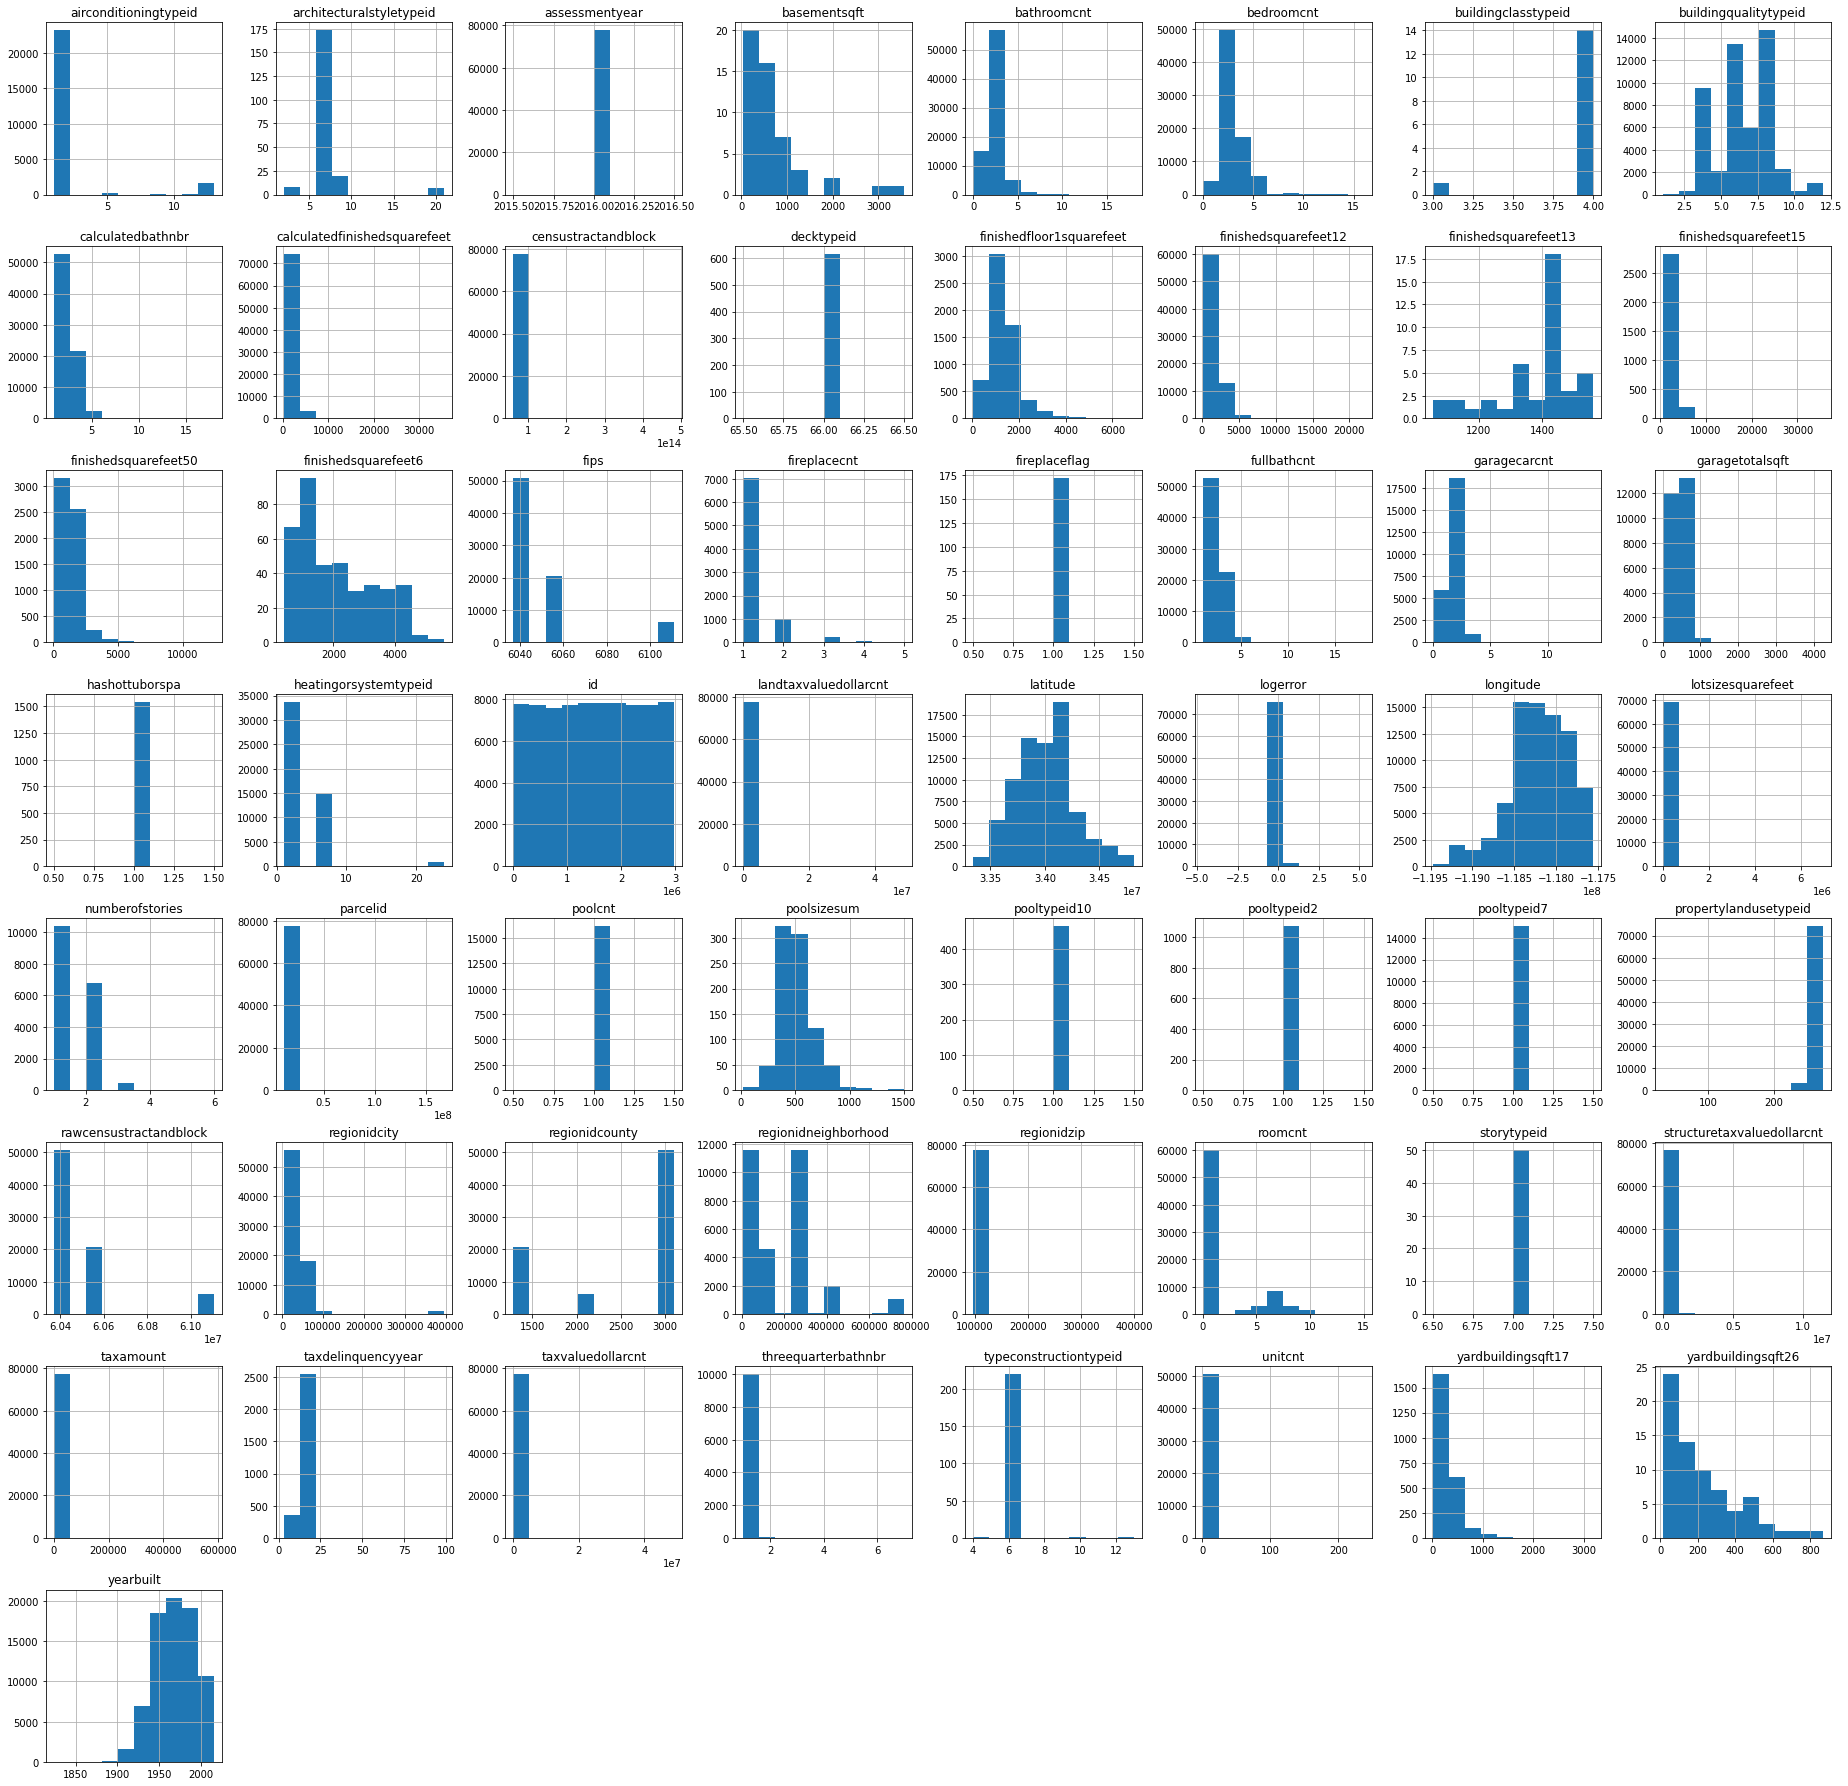

In [9]:
df.hist(figsize=(32, 32))
plt.show()

In [10]:
for c in df.columns:
    print(df[c].value_counts())
    print()

1925856    3
1968735    3
709378     3
2455685    3
1416119    2
          ..
144620     1
539885     1
1060079    1
1365232    1
2392597    1
Name: id, Length: 77381, dtype: int64

10857130    3
11991059    3
12612211    3
13083743    3
11429175    2
           ..
13968654    1
12659983    1
14154852    1
11388525    1
14298875    1
Name: parcelid, Length: 77381, dtype: int64

1.0     23186
13.0     1575
5.0       167
11.0       53
9.0        26
Name: airconditioningtypeid, dtype: int64

7.0     173
8.0      19
21.0      7
2.0       5
3.0       3
Name: architecturalstyletypeid, dtype: int64

700.0     2
515.0     2
900.0     2
912.0     2
640.0     2
273.0     2
100.0     2
3560.0    1
669.0     1
252.0     1
405.0     1
674.0     1
600.0     1
394.0     1
396.0     1
819.0     1
786.0     1
3112.0    1
1809.0    1
645.0     1
512.0     1
204.0     1
168.0     1
380.0     1
352.0     1
254.0     1
280.0     1
314.0     1
1252.0    1
112.0     1
126.0     1
800.0     1
1218.0    1
384.

Name: airconditioningdesc, dtype: int64

Contemporary     173
Conventional      19
Ranch/Rambler      7
Bungalow           5
Cape Cod           3
Name: architecturalstyledesc, dtype: int64

Buildings having wood or wood and steel frames                                                                                                                                                                                             14
Buildings having exterior walls built of a non-combustible material such as brick, concrete, block or poured concrete. Interior partitions and roof structures are built of combustible materials. Floor may be concrete or wood frame.     1
Name: buildingclassdesc, dtype: int64

Central       33633
Floor/Wall    14108
Yes             850
Forced air      777
Solar           104
None             60
Radiant          23
Baseboard        13
Gravity           3
Heat Pump         1
Name: heatingorsystemdesc, dtype: int64

Single Family Residential                     52442
Co

In [11]:
missing = pd.DataFrame({
    "num_rows_missing": df.isnull().sum(axis=0),
    "pct_rows_missing": df.isnull().sum(axis=0) / df.shape[0]
})

missing

,num_rows_missing,pct_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,52573,0.677662
architecturalstyletypeid,77373,0.997332
basementsqft,77530,0.999356
...,...,...
buildingclassdesc,77565,0.999807
heatingorsystemdesc,28008,0.361021
propertylandusedesc,0,0.000000
storydesc,77530,0.999356


In [12]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing / rows
    cols_missing = pd.DataFrame({
        "num_rows_missing": num_missing,
        "pct_rows_missing": pct_missing
    })
    return cols_missing

In [13]:
nulls_by_column = nulls_by_col(df)
nulls_by_column.sort_values(by="pct_rows_missing", ascending=False, inplace=True)
nulls_by_column.head(35)

,num_rows_missing,pct_rows_missing
buildingclassdesc,77565,0.999807
buildingclasstypeid,77565,0.999807
finishedsquarefeet13,77538,0.999459
storytypeid,77530,0.999356
basementsqft,77530,0.999356
storydesc,77530,0.999356
yardbuildingsqft26,77510,0.999098
fireplaceflag,77408,0.997783
architecturalstyletypeid,77373,0.997332
architecturalstyledesc,77373,0.997332


In [14]:
def nulls_by_row(df):
    num_cols_missing = df.isnull().sum(axis=1)
    pct_cols_missing = df.isnull().sum(axis=1) / df.shape[1]
    rows_missing = pd.DataFrame({
        'num_cols_missing': num_cols_missing,
        'pct_cols_missing': pct_cols_missing
    }).reset_index().groupby(['num_cols_missing','pct_cols_missing']).count().rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [15]:
nulls_by_row = nulls_by_row(df)
nulls_by_row.sort_values(by="pct_cols_missing", ascending=False, inplace=True)
nulls_by_row

,num_cols_missing,pct_cols_missing,num_rows
25,48,0.7058823529411765,3
24,47,0.6911764705882353,3
23,46,0.6764705882352942,5
22,45,0.6617647058823529,50
21,44,0.6470588235294118,79
20,43,0.6323529411764706,29
19,42,0.6176470588235294,27
18,41,0.6029411764705882,29
17,40,0.5882352941176471,230
16,39,0.5735294117647058,285


## Prepare

In [16]:
# remove any properties that are likely to be something other than single unit properties
df = df[df.propertylandusetypeid.isin([260, 261, 262, 279])]
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
6,781532,12095076,1.0,NaN,NaN,3.0,4.0,NaN,9.0,3.0,NaN,NaN,2962.0,2962.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34145202.0,-118179824.0,63000.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,PSR2,6.037461e+07,47019.0,3101.0,274684.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1950.0,NaN,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,NaN,NaN,1286.0,1286.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34245368.0,-118282383.0,47405.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARE40,6.037101e+07,12447.0,3101.0,27328.0,96284.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,0.020615,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77576,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,NaN,1612.0,1612.0,1612.0,NaN,NaN,1612.0,NaN,6111.0,1.0,2.0,2.0,560.0,NaN,NaN,34300140.

In [17]:
# remove any properties that are likely to be something other than single unit properties
df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0)]
df.shape

(52300, 68)

In [18]:
df.unitcnt.value_counts()

1.0    33783
2.0       28
4.0        3
3.0        1
Name: unitcnt, dtype: int64

In [19]:
df.unitcnt.isnull().sum()

18485

In [20]:
# imputing unitcnt
df.unitcnt = df.unitcnt.fillna(1.0)
df.shape

(52300, 68)

In [21]:
# filter out units with more than one unit
df = df[df.unitcnt == 1.0]
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,1.0,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,1.0,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,1.0,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
6,781532,12095076,1.0,NaN,NaN,3.0,4.0,NaN,9.0,3.0,NaN,NaN,2962.0,2962.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34145202.0,-118179824.0,63000.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,PSR2,6.037461e+07,47019.0,3101.0,274684.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1950.0,NaN,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,NaN,NaN,1286.0,1286.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34245368.0,-118282383.0,47405.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARE40,6.037101e+07,12447.0,3101.0,27328.0,96284.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,0.020615,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77576,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,NaN,1612.0,1612.0,1612.0,NaN,NaN,1612.0,NaN,6111.0,1.0,2.0,2.0,560.0,NaN,NaN,34300140.

In [22]:
df.unitcnt.value_counts()

1.0    52268
Name: unitcnt, dtype: int64

In [23]:
# dropping unnecessary columns
df.drop(columns="id", inplace=True)
df

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,1.0,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,1.0,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,1.0,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
6,12095076,1.0,NaN,NaN,3.0,4.0,NaN,9.0,3.0,NaN,NaN,2962.0,2962.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34145202.0,-118179824.0,63000.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,PSR2,6.037461e+07,47019.0,3101.0,274684.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1950.0,NaN,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,NaN,NaN,1286.0,1286.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34245368.0,-118282383.0,47405.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARE40,6.037101e+07,12447.0,3101.0,27328.0,96284.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,0.020615,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77576,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,NaN,1612.0,1612.0,1612.0,NaN,NaN,1612.0,NaN,6111.0,1.0,2.0,2.0,560.0,NaN,NaN,34300140.0,-118706327.0,12105.0,NaN,NaN,NaN,NaN,NaN,1111,261.0,NaN,6

In [24]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns=cols_to_remove)
    return df

In [25]:
def handle_missing_values(df, prop_required_column = .60, prop_required_row = .60):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [26]:
df = handle_missing_values(df)
df.shape

(52268, 33)

In [27]:
df.isnull().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18571
calculatedbathnbr                  16
calculatedfinishedsquarefeet        8
finishedsquarefeet12              166
fips                                0
fullbathcnt                        16
heatingorsystemtypeid           18369
latitude                            0
longitude                           0
lotsizesquarefeet                 351
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc              18510
rawcensustractandblock              0
regionidcity                     1029
regionidcounty                      0
regionidzip                        23
roomcnt                             0
unitcnt                             0
yearbuilt                          40
structuretaxvaluedollarcnt         71
taxvaluedollarcnt                   1
assessmentyear                      0
landtaxvalue

In [28]:
# dropping id columns
df = df.drop(columns=["propertylandusetypeid", "heatingorsystemtypeid"])

In [29]:
df.heatingorsystemdesc.isnull().sum()

18369

In [30]:
df.heatingorsystemdesc.value_counts(dropna=False)

Central       20723
NaN           18369
Floor/Wall    12542
Forced air      517
Solar            85
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [31]:
df.heatingorsystemdesc = df.heatingorsystemdesc.fillna("None")

In [32]:
df.isna().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18571
calculatedbathnbr                  16
calculatedfinishedsquarefeet        8
finishedsquarefeet12              166
fips                                0
fullbathcnt                        16
latitude                            0
longitude                           0
lotsizesquarefeet                 351
propertycountylandusecode           0
propertyzoningdesc              18510
rawcensustractandblock              0
regionidcity                     1029
regionidcounty                      0
regionidzip                        23
roomcnt                             0
unitcnt                             0
yearbuilt                          40
structuretaxvaluedollarcnt         71
taxvaluedollarcnt                   1
assessmentyear                      0
landtaxvaluedollarcnt               1
taxamount                           4
censustracta

In [33]:
df.propertyzoningdesc.value_counts()

LAR1          6486
LARS          1385
LBR1N         1111
SCUR2          712
LARE11         611
              ... 
GACP             1
POR115000H       1
PDRI             1
LCR16000-R       1
PDA12 1/2*       1
Name: propertyzoningdesc, Length: 1280, dtype: int64

In [34]:
df = df.drop(columns="propertyzoningdesc")
df.shape

(52268, 30)

In [35]:
df.isna().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18571
calculatedbathnbr                  16
calculatedfinishedsquarefeet        8
finishedsquarefeet12              166
fips                                0
fullbathcnt                        16
latitude                            0
longitude                           0
lotsizesquarefeet                 351
propertycountylandusecode           0
rawcensustractandblock              0
regionidcity                     1029
regionidcounty                      0
regionidzip                        23
roomcnt                             0
unitcnt                             0
yearbuilt                          40
structuretaxvaluedollarcnt         71
taxvaluedollarcnt                   1
assessmentyear                      0
landtaxvaluedollarcnt               1
taxamount                           4
censustractandblock               109
logerror    

In [36]:
# overall assessment of condition of the building from best (lowest) to worst (highest)
df.buildingqualitytypeid.value_counts(dropna=False)

NaN     18571
6.0     10280
8.0      8243
4.0      8146
7.0      3422
5.0      1500
9.0      1122
11.0      515
10.0      228
3.0       150
12.0       80
1.0         8
2.0         3
Name: buildingqualitytypeid, dtype: int64

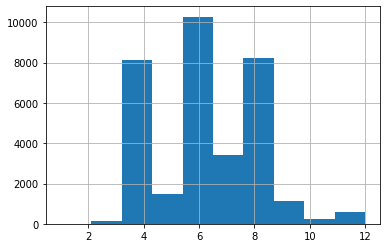

In [37]:
df.buildingqualitytypeid.hist(bins=10)

In [38]:
df.buildingqualitytypeid.mean()

6.265513250437724

In [39]:
df.buildingqualitytypeid.median()

6.0

In [40]:
df.buildingqualitytypeid.mode()

0    6.0
dtype: float64

In [41]:
df.buildingqualitytypeid = df.buildingqualitytypeid.fillna(df.buildingqualitytypeid.median())
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,14297519,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential
1,17052889,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential
2,14186244,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential
3,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential
6,12095076,3.0,4.0,9.0,3.0,2962.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,11000655,2.0,2.0,6.0,2.0,1286.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,0100,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Central,Single Family Residential
77576,17239384,2.0,4.0,6.0,2.0,1612.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,1111,6.111008e+07,27110.0,2061.0,97116.0,7.0,1.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,None,Single Family Residential
77577,12773139,1.0,3.0,4.0,1.0,1032.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,0100,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Single Family Residential
77578,12826780,2.0,3.0,6.0,2.0,1762.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,0100,6.037503e+07,14634.0,3101.0,96171.0,0.0,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,Central,Single Family Residential


In [42]:
df.isnull().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                 16
calculatedfinishedsquarefeet       8
finishedsquarefeet12             166
fips                               0
fullbathcnt                       16
latitude                           0
longitude                          0
lotsizesquarefeet                351
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                         40
structuretaxvaluedollarcnt        71
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
censustractandblock              109
logerror                           0
t

In [43]:
# impute lotsizesquarefeet
df.lotsizesquarefeet.value_counts(dropna=False)

6000.0     876
5000.0     414
NaN        351
7200.0     307
7000.0     286
          ... 
3587.0       1
37506.0      1
9046.0       1
21602.0      1
38906.0      1
Name: lotsizesquarefeet, Length: 14235, dtype: int64

In [44]:
df.lotsizesquarefeet.mean()

11237.13587071672

In [45]:
df.lotsizesquarefeet.median()

6837.0

In [46]:
df.lotsizesquarefeet.mode()

0    6000.0
dtype: float64

In [47]:
df.lotsizesquarefeet = df.lotsizesquarefeet.fillna(6000.0)
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,14297519,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential
1,17052889,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential
2,14186244,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential
3,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential
6,12095076,3.0,4.0,9.0,3.0,2962.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,11000655,2.0,2.0,6.0,2.0,1286.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,0100,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Central,Single Family Residential
77576,17239384,2.0,4.0,6.0,2.0,1612.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,1111,6.111008e+07,27110.0,2061.0,97116.0,7.0,1.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,None,Single Family Residential
77577,12773139,1.0,3.0,4.0,1.0,1032.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,0100,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Single Family Residential
77578,12826780,2.0,3.0,6.0,2.0,1762.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,0100,6.037503e+07,14634.0,3101.0,96171.0,0.0,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,Central,Single Family Residential


In [48]:
df.isnull().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                 16
calculatedfinishedsquarefeet       8
finishedsquarefeet12             166
fips                               0
fullbathcnt                       16
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                         40
structuretaxvaluedollarcnt        71
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
censustractandblock              109
logerror                           0
t

In [49]:
# impute calculatedbathnbr
df.calculatedbathnbr.value_counts(dropna=False)

2.0     21879
3.0     10666
1.0      9549
2.5      3925
4.0      2221
3.5       918
1.5       834
5.0       803
4.5       686
6.0       319
5.5       223
7.0        88
8.0        53
6.5        47
NaN        16
7.5        16
9.0        13
10.0        5
8.5         3
11.0        3
13.0        1
Name: calculatedbathnbr, dtype: int64

In [50]:
df[df.calculatedbathnbr == 2].shape[0] / df.shape[0]

0.41859263794290963

In [51]:
df.calculatedbathnbr.mode()

0    2.0
dtype: float64

In [52]:
df.calculatedbathnbr.median()

2.0

In [53]:
df.calculatedbathnbr.mean()

2.304447676643956

In [54]:
df.calculatedbathnbr = df.calculatedbathnbr.fillna(df.calculatedbathnbr.median())

In [55]:
df.calculatedbathnbr.value_counts(dropna=False)

2.0     21895
3.0     10666
1.0      9549
2.5      3925
4.0      2221
3.5       918
1.5       834
5.0       803
4.5       686
6.0       319
5.5       223
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
8.5         3
11.0        3
13.0        1
Name: calculatedbathnbr, dtype: int64

In [56]:
df.isnull().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       8
finishedsquarefeet12             166
fips                               0
fullbathcnt                       16
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                         40
structuretaxvaluedollarcnt        71
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
censustractandblock              109
logerror                           0
t

In [57]:
# impute calculatedfinishedsquarefeet
df.calculatedfinishedsquarefeet.value_counts(dropna=False)

1120.0    127
1200.0    118
1080.0    102
1040.0     86
936.0      86
         ... 
5674.0      1
8288.0      1
5408.0      1
519.0       1
5984.0      1
Name: calculatedfinishedsquarefeet, Length: 4712, dtype: int64

In [58]:
df.calculatedfinishedsquarefeet.median()

1659.0

In [59]:
df.calculatedfinishedsquarefeet.mean()

1922.6174129353233

In [60]:
df.calculatedfinishedsquarefeet.mode()

0    1120.0
dtype: float64

In [61]:
# imputing with mode
df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.fillna(1120.0)
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,14297519,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential
1,17052889,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential
2,14186244,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential
3,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential
6,12095076,3.0,4.0,9.0,3.0,2962.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,11000655,2.0,2.0,6.0,2.0,1286.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,0100,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Central,Single Family Residential
77576,17239384,2.0,4.0,6.0,2.0,1612.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,1111,6.111008e+07,27110.0,2061.0,97116.0,7.0,1.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,None,Single Family Residential
77577,12773139,1.0,3.0,4.0,1.0,1032.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,0100,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Single Family Residential
77578,12826780,2.0,3.0,6.0,2.0,1762.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,0100,6.037503e+07,14634.0,3101.0,96171.0,0.0,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,Central,Single Family Residential


In [62]:
df.calculatedfinishedsquarefeet.value_counts()

1120.0    135
1200.0    118
1080.0    102
1040.0     86
936.0      86
         ... 
8288.0      1
5408.0      1
519.0       1
4533.0      1
3817.0      1
Name: calculatedfinishedsquarefeet, Length: 4711, dtype: int64

In [63]:
df.isna().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       0
finishedsquarefeet12             166
fips                               0
fullbathcnt                       16
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                         40
structuretaxvaluedollarcnt        71
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
censustractandblock              109
logerror                           0
t

In [64]:
df.shape[1]

30

In [65]:
# imputing finishedsquarefeet12
df.finishedsquarefeet12.value_counts()

1120.0    126
1200.0    117
1080.0    102
936.0      86
1040.0     85
         ... 
3856.0      1
6595.0      1
5202.0      1
4887.0      1
4928.0      1
Name: finishedsquarefeet12, Length: 4705, dtype: int64

In [66]:
# 99.7% of the values in finishedsquarefeet12 are the same as calculatedfinishedsquarefeet
# it is reasonable to fill the missing values in finishedsquarefeet12 with the values for calculatedfinishedsquarefeet
# may consider dropping the column all together as the info appears to be redundant
df[df.calculatedfinishedsquarefeet == df.finishedsquarefeet12].shape[0] / df.shape[0]

0.9968240606106987

In [67]:
df.finishedsquarefeet12 = df.finishedsquarefeet12.fillna(df.calculatedfinishedsquarefeet)

In [68]:
df.finishedsquarefeet12.value_counts()

1120.0    135
1200.0    118
1080.0    102
1040.0     86
936.0      86
         ... 
8288.0      1
5408.0      1
519.0       1
4533.0      1
3817.0      1
Name: finishedsquarefeet12, Length: 4711, dtype: int64

In [69]:
df.drop(columns="finishedsquarefeet12", inplace=True)
df.isna().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                       16
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                         40
structuretaxvaluedollarcnt        71
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
censustractandblock              109
logerror                           0
transactiondate                    0
h

In [70]:
# went ahead and dropped the column as there's no added values in keeping it
df.shape[1]

29

In [71]:
# imputing fullbathcnt
df[df.bathroomcnt == df.fullbathcnt].shape[0] / df.shape[0]

0.8710874722583608

In [72]:
df.fullbathcnt.value_counts()

2.0     25816
3.0     11593
1.0     10383
4.0      2908
5.0      1022
6.0       356
7.0        96
8.0        56
9.0        13
10.0        5
11.0        3
13.0        1
Name: fullbathcnt, dtype: int64

In [73]:
df.fullbathcnt.median()

2.0

In [74]:
df.fullbathcnt.mode()

0    2.0
dtype: float64

In [75]:
df.fullbathcnt.mean()

2.2392444308351833

In [76]:
df.fullbathcnt = df.fullbathcnt.fillna(df.fullbathcnt.median())
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential
6,12095076,3.0,4.0,9.0,3.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,11000655,2.0,2.0,6.0,2.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,0100,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Central,Single Family Residential
77576,17239384,2.0,4.0,6.0,2.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,1111,6.111008e+07,27110.0,2061.0,97116.0,7.0,1.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,None,Single Family Residential
77577,12773139,1.0,3.0,4.0,1.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,0100,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Single Family Residential
77578,12826780,2.0,3.0,6.0,2.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,0100,6.037503e+07,14634.0,3101.0,96171.0,0.0,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,Central,Single Family Residential


In [77]:
df.isna().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                        0
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                         40
structuretaxvaluedollarcnt        71
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
censustractandblock              109
logerror                           0
transactiondate                    0
h

In [78]:
# imputing year built
df.yearbuilt.value_counts().head(20)

1955.0    1897
1950.0    1604
1954.0    1521
1953.0    1484
1956.0    1387
1964.0    1302
1952.0    1201
1951.0    1189
1959.0    1066
1963.0    1016
1947.0    1006
1957.0    1006
1962.0     999
1965.0     987
1949.0     967
1948.0     929
1960.0     878
1989.0     832
1961.0     816
1977.0     802
Name: yearbuilt, dtype: int64

In [79]:
round(df.yearbuilt.mean())

1963

In [80]:
df.yearbuilt.mode()

0    1955.0
dtype: float64

In [81]:
df.yearbuilt.median()

1961.0

In [82]:
df.yearbuilt = df.yearbuilt.fillna(round(df.yearbuilt.mean()))
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential
6,12095076,3.0,4.0,9.0,3.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,11000655,2.0,2.0,6.0,2.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,0100,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Central,Single Family Residential
77576,17239384,2.0,4.0,6.0,2.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,1111,6.111008e+07,27110.0,2061.0,97116.0,7.0,1.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,None,Single Family Residential
77577,12773139,1.0,3.0,4.0,1.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,0100,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Single Family Residential
77578,12826780,2.0,3.0,6.0,2.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,0100,6.037503e+07,14634.0,3101.0,96171.0,0.0,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,Central,Single Family Residential


In [83]:
df.yearbuilt.value_counts().head(10)

1955.0    1897
1950.0    1604
1954.0    1521
1953.0    1484
1956.0    1387
1964.0    1302
1952.0    1201
1951.0    1189
1959.0    1066
1963.0    1056
Name: yearbuilt, dtype: int64

In [84]:
df.isna().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                        0
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                          0
structuretaxvaluedollarcnt        71
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
censustractandblock              109
logerror                           0
transactiondate                    0
h

In [85]:
# imputing structuretaxvaluedollarcnt
df.structuretaxvaluedollarcnt.value_counts().head(30)

100000.0    49
200000.0    36
90000.0     32
32489.0     28
95000.0     26
101525.0    25
39948.0     25
110000.0    24
101000.0    24
27935.0     24
104000.0    24
34354.0     23
99000.0     23
203050.0    23
30628.0     22
120000.0    22
29594.0     22
120100.0    22
155000.0    22
150000.0    22
36634.0     22
43674.0     22
31038.0     21
38700.0     21
91000.0     21
41816.0     21
21513.0     21
115000.0    21
28767.0     21
33112.0     21
Name: structuretaxvaluedollarcnt, dtype: int64

In [86]:
df.structuretaxvaluedollarcnt.mean()

195836.12903040406

In [87]:
df.structuretaxvaluedollarcnt.median()

131717.0

In [88]:
df.structuretaxvaluedollarcnt.mode()

0    100000.0
dtype: float64

In [89]:
df[df.structuretaxvaluedollarcnt == df.structuretaxvaluedollarcnt.median()]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
42250,14072082,2.0,3.0,6.0,2.0,1812.0,6059.0,2.0,33714390.0,-117960290.0,6600.0,122,6.059099e+07,8384.0,1286.0,97008.0,6.0,1.0,1966.0,131717.0,446509.0,2016.0,314792.0,5004.9,6.059099e+13,-0.047313,2017-06-01,None,Single Family Residential


In [90]:
df.structuretaxvaluedollarcnt.max()

9164901.0

In [91]:
# 99.9% of the values in structuretaxvaluedollarcnt are equal to the different between taxvaluedollarcnt
# and landtaxvaluedollarcnt
# I will impute based on this difference as the metrics above were not satisfactory
df[df.structuretaxvaluedollarcnt == df.taxvaluedollarcnt - df.landtaxvaluedollarcnt].shape[0] / df.shape[0]

0.9986416162852988

In [92]:
df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(df.taxvaluedollarcnt - df.landtaxvaluedollarcnt)
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential
6,12095076,3.0,4.0,9.0,3.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,11000655,2.0,2.0,6.0,2.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,0100,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Central,Single Family Residential
77576,17239384,2.0,4.0,6.0,2.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,1111,6.111008e+07,27110.0,2061.0,97116.0,7.0,1.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,None,Single Family Residential
77577,12773139,1.0,3.0,4.0,1.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,0100,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Single Family Residential
77578,12826780,2.0,3.0,6.0,2.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,0100,6.037503e+07,14634.0,3101.0,96171.0,0.0,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,Central,Single Family Residential


In [93]:
df.isna().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                        0
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                          0
structuretaxvaluedollarcnt         1
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
censustractandblock              109
logerror                           0
transactiondate                    0
h

In [94]:
# still one row missing a structuretaxvaluedollarcnt value
# probably the same row as the missing taxvaluedollarcnt and landtaxvaluedollarcnt
df[(df.structuretaxvaluedollarcnt.isna() == True) & (df.taxvaluedollarcnt.isna() == True) & (df.landtaxvaluedollarcnt.isna() == True)]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
62533,14006983,2.0,4.0,6.0,2.0,1197.0,6059.0,2.0,33792921.0,-117982046.0,7210.0,122,6.059088e+07,24832.0,1286.0,97048.0,7.0,1.0,1954.0,NaN,NaN,2016.0,NaN,388.18,6.059088e+13,-0.03679,2017-07-31,None,Single Family Residential


In [95]:
df[df.parcelid == 14006983]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
62533,14006983,2.0,4.0,6.0,2.0,1197.0,6059.0,2.0,33792921.0,-117982046.0,7210.0,122,6.059088e+07,24832.0,1286.0,97048.0,7.0,1.0,1954.0,NaN,NaN,2016.0,NaN,388.18,6.059088e+13,-0.03679,2017-07-31,None,Single Family Residential


In [96]:
# df.drop(index=62533, inplace=True)
# df

In [97]:
df.drop(index=df[df.structuretaxvaluedollarcnt.isna() == True].index.tolist(), inplace=True)
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential
6,12095076,3.0,4.0,9.0,3.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,11000655,2.0,2.0,6.0,2.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,0100,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Central,Single Family Residential
77576,17239384,2.0,4.0,6.0,2.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,1111,6.111008e+07,27110.0,2061.0,97116.0,7.0,1.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,None,Single Family Residential
77577,12773139,1.0,3.0,4.0,1.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,0100,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Single Family Residential
77578,12826780,2.0,3.0,6.0,2.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,0100,6.037503e+07,14634.0,3101.0,96171.0,0.0,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,Central,Single Family Residential


In [98]:
df.isna().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                        0
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                          0
structuretaxvaluedollarcnt         0
taxvaluedollarcnt                  0
assessmentyear                     0
landtaxvaluedollarcnt              0
taxamount                          4
censustractandblock              109
logerror                           0
transactiondate                    0
h

In [99]:
# impute taxamount
df[df.taxamount.isna() == True]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
5360,11666665,3.0,4.0,7.0,3.0,2587.0,6037.0,3.0,34048939.0,-118544920.0,9775.0,0104,6.037263e+07,12447.0,3101.0,96120.0,0.0,1.0,1954.0,448740.0,2030499.0,2016.0,1581759.0,NaN,6.037263e+13,-0.043649,2017-01-25,Central,Single Family Residential
12397,11647249,3.0,4.0,9.0,3.0,2924.0,6037.0,3.0,34070466.0,-118462732.0,6000.0,0101,6.037265e+07,12447.0,3101.0,96030.0,0.0,1.0,1954.0,0.0,461231.0,2016.0,461231.0,NaN,6.037265e+13,0.038192,2017-02-24,Central,Single Family Residential
26152,11487838,1.0,3.0,6.0,1.0,1239.0,6037.0,1.0,33874473.0,-118364035.0,6760.0,0100,6.037621e+07,33612.0,3101.0,96124.0,0.0,1.0,1953.0,188633.0,943166.0,2016.0,754533.0,NaN,6.037621e+13,0.689382,2017-04-13,Floor/Wall,Single Family Residential
39107,12920381,2.0,3.0,5.0,2.0,944.0,6037.0,2.0,34099255.0,-117891371.0,7489.0,0100,6.037406e+07,24245.0,3101.0,96473.0,0.0,1.0,1930.0,75000.0,352000.0,2016.0,277000.0,NaN,6.037406e+13,-0.121397,2017-05-24,Floor/Wall,Single Family Residential


In [100]:
df[df["taxamount"].isna() == True]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
5360,11666665,3.0,4.0,7.0,3.0,2587.0,6037.0,3.0,34048939.0,-118544920.0,9775.0,0104,6.037263e+07,12447.0,3101.0,96120.0,0.0,1.0,1954.0,448740.0,2030499.0,2016.0,1581759.0,NaN,6.037263e+13,-0.043649,2017-01-25,Central,Single Family Residential
12397,11647249,3.0,4.0,9.0,3.0,2924.0,6037.0,3.0,34070466.0,-118462732.0,6000.0,0101,6.037265e+07,12447.0,3101.0,96030.0,0.0,1.0,1954.0,0.0,461231.0,2016.0,461231.0,NaN,6.037265e+13,0.038192,2017-02-24,Central,Single Family Residential
26152,11487838,1.0,3.0,6.0,1.0,1239.0,6037.0,1.0,33874473.0,-118364035.0,6760.0,0100,6.037621e+07,33612.0,3101.0,96124.0,0.0,1.0,1953.0,188633.0,943166.0,2016.0,754533.0,NaN,6.037621e+13,0.689382,2017-04-13,Floor/Wall,Single Family Residential
39107,12920381,2.0,3.0,5.0,2.0,944.0,6037.0,2.0,34099255.0,-117891371.0,7489.0,0100,6.037406e+07,24245.0,3101.0,96473.0,0.0,1.0,1930.0,75000.0,352000.0,2016.0,277000.0,NaN,6.037406e+13,-0.121397,2017-05-24,Floor/Wall,Single Family Residential


In [101]:
df[df.taxamount.isna() == True].index.tolist()

[5360, 12397, 26152, 39107]

In [102]:
df.taxamount.value_counts()

345.72      4
1625.61     3
3347.58     3
5170.36     3
4012.74     3
           ..
3395.48     1
1923.96     1
1776.35     1
3729.46     1
10240.00    1
Name: taxamount, Length: 50672, dtype: int64

In [103]:
df.taxamount.mean()

6421.61967740084

In [104]:
df.taxamount.median()

4647.05

In [105]:
df.taxamount.mode()

0    345.72
dtype: float64

In [106]:
df.drop(index=df[df.taxamount.isna() == True].index.tolist(), inplace=True)

In [107]:
df.isna().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                        0
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                          0
structuretaxvaluedollarcnt         0
taxvaluedollarcnt                  0
assessmentyear                     0
landtaxvaluedollarcnt              0
taxamount                          0
censustractandblock              109
logerror                           0
transactiondate                    0
h

In [108]:
df.censustractandblock

0        6.059063e+13
1        6.111001e+13
2        6.059022e+13
3        6.037300e+13
6        6.037461e+13
             ...     
77575    6.037101e+13
77576    6.111008e+13
77577    6.037434e+13
77578    6.037503e+13
77579    6.037408e+13
Name: censustractandblock, Length: 52263, dtype: float64

In [109]:
df.rawcensustractandblock

0        6.059063e+07
1        6.111001e+07
2        6.059022e+07
3        6.037300e+07
6        6.037461e+07
             ...     
77575    6.037101e+07
77576    6.111008e+07
77577    6.037434e+07
77578    6.037503e+07
77579    6.037408e+07
Name: rawcensustractandblock, Length: 52263, dtype: float64

In [110]:
df.isna().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedbathnbr                  0
calculatedfinishedsquarefeet       0
fips                               0
fullbathcnt                        0
latitude                           0
longitude                          0
lotsizesquarefeet                  0
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1029
regionidcounty                     0
regionidzip                       23
roomcnt                            0
unitcnt                            0
yearbuilt                          0
structuretaxvaluedollarcnt         0
taxvaluedollarcnt                  0
assessmentyear                     0
landtaxvaluedollarcnt              0
taxamount                          0
censustractandblock              109
logerror                           0
transactiondate                    0
h

In [111]:
df.drop(index=df[df.censustractandblock.isna() == True].index.tolist(), inplace=True) 

In [112]:
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential
6,12095076,3.0,4.0,9.0,3.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,11000655,2.0,2.0,6.0,2.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,47405.0,0100,6.037101e+07,12447.0,3101.0,96284.0,0.0,1.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Central,Single Family Residential
77576,17239384,2.0,4.0,6.0,2.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,12105.0,1111,6.111008e+07,27110.0,2061.0,97116.0,7.0,1.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,None,Single Family Residential
77577,12773139,1.0,3.0,4.0,1.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,5074.0,0100,6.037434e+07,36502.0,3101.0,96480.0,0.0,1.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Single Family Residential
77578,12826780,2.0,3.0,6.0,2.0,1762.0,6037.0,2.0,33937685.0,-117996709.0,6347.0,0100,6.037503e+07,14634.0,3101.0,96171.0,0.0,1.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,Central,Single Family Residential


In [113]:
df.isna().sum()

parcelid                          0
bathroomcnt                       0
bedroomcnt                        0
buildingqualitytypeid             0
calculatedbathnbr                 0
calculatedfinishedsquarefeet      0
fips                              0
fullbathcnt                       0
latitude                          0
longitude                         0
lotsizesquarefeet                 0
propertycountylandusecode         0
rawcensustractandblock            0
regionidcity                    999
regionidcounty                    0
regionidzip                       2
roomcnt                           0
unitcnt                           0
yearbuilt                         0
structuretaxvaluedollarcnt        0
taxvaluedollarcnt                 0
assessmentyear                    0
landtaxvaluedollarcnt             0
taxamount                         0
censustractandblock               0
logerror                          0
transactiondate                   0
heatingorsystemdesc         

In [114]:
df.regionidzip.value_counts()

97319.0    771
97318.0    668
97329.0    562
97328.0    519
97118.0    498
          ... 
96434.0      2
96467.0      1
97092.0      1
96038.0      1
96148.0      1
Name: regionidzip, Length: 379, dtype: int64

In [115]:
df[df.regionidzip.isna() == True].index.tolist()

[18524, 36114]

In [116]:
df[(df.regionidcounty == 2061.0) & (df.regionidcity == 34543.0)].regionidzip.value_counts()

97083.0    232
97084.0    181
97081.0    147
97092.0      1
Name: regionidzip, dtype: int64

In [117]:
df[(df.regionidcounty == 2061.0) & (df.regionidcity == 34543.0)].regionidzip.mode()

0    97083.0
dtype: float64

In [118]:
df[(df.regionidcounty == 2061.0) & (df.regionidcity == 34543.0)].regionidzip.median()

97083.0

In [119]:
df[(df.regionidcounty == 1286.0) & (df.regionidcity == 53571.0)].regionidzip.value_counts()

96978.0    279
96957.0    127
96981.0    126
96979.0     43
96980.0     16
96959.0      9
Name: regionidzip, dtype: int64

In [120]:
df[(df.regionidcounty == 1286.0) & (df.regionidcity == 53571.0)].regionidzip.mode()

0    96978.0
dtype: float64

In [121]:
df[(df.regionidcounty == 1286.0) & (df.regionidcity == 53571.0)].regionidzip.median()

96978.0

In [122]:
df.drop(index=df[df.regionidzip.isna() == True].index.tolist(), inplace=True)

In [123]:
df.isna().sum()

parcelid                          0
bathroomcnt                       0
bedroomcnt                        0
buildingqualitytypeid             0
calculatedbathnbr                 0
calculatedfinishedsquarefeet      0
fips                              0
fullbathcnt                       0
latitude                          0
longitude                         0
lotsizesquarefeet                 0
propertycountylandusecode         0
rawcensustractandblock            0
regionidcity                    999
regionidcounty                    0
regionidzip                       0
roomcnt                           0
unitcnt                           0
yearbuilt                         0
structuretaxvaluedollarcnt        0
taxvaluedollarcnt                 0
assessmentyear                    0
landtaxvaluedollarcnt             0
taxamount                         0
censustractandblock               0
logerror                          0
transactiondate                   0
heatingorsystemdesc         

In [124]:
df.regionidcity.value_counts()

12447.0    11396
5534.0      1783
40227.0     1489
46298.0     1427
16764.0     1081
           ...  
32927.0        3
31134.0        2
10815.0        1
36078.0        1
21395.0        1
Name: regionidcity, Length: 175, dtype: int64

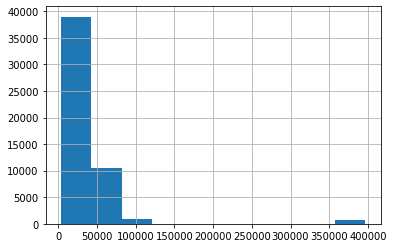

In [125]:
df.regionidcity.hist()
plt.show()

In [126]:
df[df.regionidcity == 12447.0].shape[0] / df.shape[0]

0.2185151096793987

### Train/Validate/Test Split

In [127]:
train, test = train_test_split(df, train_size=.8, random_state=56)

In [128]:
print(f"train shape = {train.shape}")
print(f" test shape = {test.shape}")

train shape = (41721, 29)
 test shape = (10431, 29)


In [129]:
train, validate = train_test_split(train, train_size=.75, random_state=56)

In [130]:
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (31290, 29)
validate shape = (10431, 29)
    test shape = (10431, 29)


In [131]:
train.regionidcity.value_counts(dropna=False)

12447.0    6794
5534.0     1071
40227.0     891
46298.0     887
16764.0     661
           ... 
13311.0       3
31134.0       2
32927.0       2
21395.0       1
36078.0       1
Name: regionidcity, Length: 175, dtype: int64

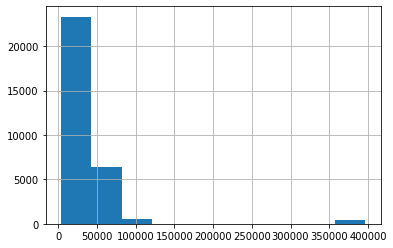

In [132]:
train.regionidcity.hist()
plt.show()

In [133]:
train[train.regionidcity == 12447.0].shape[0] / train.shape[0]

0.21713007350591243

In [134]:
# impute regionidcity using KNN
imputer = KNNImputer()
imputer.fit(train[["regionidcity"]])
train["regionidcity"] = imputer.transform(train[["regionidcity"]])
validate["regionidcity"] = imputer.transform(validate[["regionidcity"]])
test["regionidcity"] = imputer.transform(test[["regionidcity"]])

In [135]:
train[train.regionidcity.isna() == True]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
